In [1]:
alias qstat /opt/pbs/bin/qstat -u $USER

In [1]:
import os, sys
import ase
import ase.calculators.vasp
import ase.io 
import ase.units
import ase.eos
from ase.visualize import view
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import mywrapper

The cohesive energy is defined as the energy required to bring the atoms together to form the solid. We will calculate it as the difference between the energies of isolated atom and atoms in solid. <br />

The calculation of atom inside solid is straightforward, we simply get the energy of periodic solid and divide it be number of atoms. <br />

For isolated atom, we need to put the atom inside the vacuum. We need to add enough vacuum to make sure that atom does not interact with its periodic image (periodic images will present due to planewave DFT).

In [2]:
# energy of atoms inside solid

# get atomic object
a = 5.5
cell = [[a,0,0], [0,a,0], [0,0,a]]
atoms = ase.Atoms([ase.Atom('Cu', [0.0,0.0,0.0]), 
                    ase.Atom('Cu', [0.5*a, 0.5*a, 0.0*a]),
                    ase.Atom('Cu', [0.5*a, 0.0*a, 0.5*a]),
                    ase.Atom('Cu', [0.0*a, 0.5*a, 0.5*a]),])
atoms.set_cell(cell)
natom = len(atoms.get_positions())

# set calculator to relax everything
calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[8,8,8],
            encut=400,
            ediff=1e-5,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,   
            npar=2, 
            isif=3,
            ibrion=2,
            nsw=100,
            ediffg=(1e-3),
            )
atoms.set_calculator(calc)

path = "Cu/bulk/"
bulk_energy = mywrapper.get_energy(atoms, dir=path) / natom
print(bulk_energy)
ase.visualize.view(atoms)

-3.75147482


Vacuum (A) | dE (meV) | if converged?
----------------------------------------
  6         278.574     0
  8          30.934     0
 10           2.685     0
 12           0.555     1
 14           0.382     1
 16           0.000     1


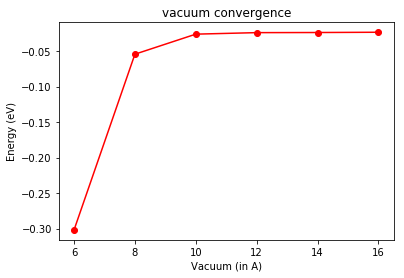

In [3]:
# now lets do vacuum convergence to make sure that there are no interactions

atoms = ase.Atoms([ase.Atom('Cu', [0.0,0.0,0.0])])
cell = np.array([[1,0,0],[0,1,0], [0,0,1]])

vacuums = [6,8,10,12,14,16]
energies = []

pwd = os.getcwd()
for vac in vacuums:
    
    os.chdir(pwd)
    path = 'Cu/vaccum/%d' % (vac)
    calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[1,1,1],               # Notice that we are using only [1,1,1] here as system is non-periodic
            encut=400,
            ediff=1e-5,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,   
            npar=2, 
            )    
    
    atoms.set_cell(vac * cell, scale_atoms=True)
    atoms.set_calculator(calc)
    energy = mywrapper.get_energy(atoms, dir=path)
    energies.append(energy)
    os.chdir(path)
    
    

ase.visualize.view(atoms)   
    
plt.figure(0)
plt.plot(vacuums, energies, 'ro-')
plt.xlabel('Vacuum (in A)')
plt.ylabel('Energy (eV)')
plt.title('vacuum convergence')


diff_energies = abs(1000*(np.array(energies)-np.array(energies[-1])))
print("Vacuum (A) | dE (meV) | if converged?")
print('-'*40)
for v,e in zip(vacuums, diff_energies):
    print('%3d %15.3f %5d' % (v, e, e<2))

In [4]:
print('Cohesive enegry of Cu: %5.3f eV/atom' % (energies[-3] - bulk_energy))

Cohesive enegry of Cu: 3.728 eV/atom


The literature reported value is [`3.49 eV/atom`](https://sites.google.com/site/zrftum/home/l/physical-properties/cohesive-energy-of-elements). Could you think of some reasons why our value is higher?